In [1]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import timeit
from textblob import TextBlob
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
# unzip the dataset
import os
zip_path = os.path.join(os.path.join('drive', 'My Drive', 'Dissertation'), 'df_news_combined.csv.zip')
!cp '{zip_path}' .
!yes|unzip -q df_news_combined.csv.zip
!rm df_news_combined.csv.zip
print(os.listdir(os.path.join('drive', 'My Drive', 'Dissertation')))

['df_news_combined.csv.zip', 'trails.ipynb', 'lstm_base_and_tuned.ipynb', 'cnn_base_and_tuned.ipynb', 'gru_base_and_tuned.ipynb', 'xgboost_base_and_tuned.ipynb', 'random_forest_base_and_tuned.ipynb']


In [4]:
# reference - https://colab.research.google.com/notebooks/gpu.ipynb
# activate the gpu
def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
gpu()
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)

GPU (s):
1.2006076130000167


In [5]:
# read the dataset
df_news_com = pd.read_csv('df_news_combined.csv')
df_news_com

,TITLE,ARTICLE LINK,AUTHOR,PUBLISHER,COUNTRY,CATEGORY,LANGUAGE,DESCRIPTION,IMAGE URL,VIDEO URL,DATE,GMT,POSTAG
0,"""Business duo turn over $70K a month with thei...",https://www.dailymail.co.uk/femail/article-107...,Unknown,Mail Online,United Kingdom,Food,English,business duo create home hair kit bridge gap b...,https://i.dailymail.co.uk/1s/2022/04/29/05/571...,Unknown,05/01/2022,00:16,"[('business', 'NN'), ('duo', 'NN'), ('created'..."
1,"""People Are Sharing ""Impulsive And Expensive"" ...",https://www.buzzfeed.com/fabianabuontempo/peop...,Unknown,Buzzfeed,United Kingdom,Food,English,definitely need love make confident secure hap...,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('definitely', 'RB'), ('need', 'MD'), ('love'..."
2,"""Why You Shouldn't Butter The Pan When Making ...",https://www.buzzfeed.com/rossyoder/culinary-sc...,Unknown,Buzzfeed,United Kingdom,Food,English,class session view entire post,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('class', 'NN'), ('session', 'NN'), ('view', ..."
3,"""Quaint beachside cottage on the Mornington Pe...",https://www.dailymail.co.uk/femail/homes/artic...,Unknown,Mail Online,United Kingdom,Food,English,ultra chic contemporary home lap pool tennis c...,https://i.dailymail.co.uk/1s/2022/04/29/07/571...,Unknown,05/01/2022,00:53,"[('ultra', 'JJ'), ('chic', 'JJ'), ('contempora..."
4,"""Viral Tiktok claims Sunnyboys were back at Wo...",https://www.dailymail.co.uk/femail/food/articl...,Unknown,Mail Online,United Kingdom,Food,English,australian shoppers send spin tiktok clip go v...,https://i.dailymail.co.uk/1s/2022/05/01/02/572...,Unknown,05/01/2022,01:32,"[('australian', 'JJ'), ('shoppers', 'NNS'), ('..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823100,"""'New Zealand condemns Russias annexation atte...",http://www.voxy.co.nz/politics/5/407843,Unknown,Voxy,New Zealand,Politics,English,new zealand condemn unequivocally russias atte...,Unknown,Unknown,30/09/2022,23:02,"[('new', 'JJ'), ('zealand', 'NNP'), ('condemns..."
823101,"""Nigeria @ 62: So far, not so good""",https://punchng.com/nigeria-62-so-far-not-so-g...,Our Reporters,Punch,Nigeria,Politics,English,leke baiyewu abiodun sanusi x ray political hi...,Unknown,Unknown,30/09/2022,23:25,"[('leke', 'NN'), ('baiyewu', 'NN'), ('abiodun'..."
823102,"""Most Voters Say Trump Should Not Be Allowed T...",https://www.huffpost.com/entry/voters-donald-t...,Unknown,Huffpost,United States Of America,Politics,English,apparently go give know ongoing investigations...,Unknown,Unknown,30/09/2022,23:25,"[('apparently', 'RB'), ('go', 'VB'), ('given',..."
823103,"""Babayemi congratulates Adeleke on Supreme Cou...",https://punchng.com/babayemi-congratulates-ade...,Bola Bamigbola,Punch,Nigeria,Politics,English,former governorship aspirant platform people d...,Unknown,Unknown,30/09/2022,23:44,"[('former', 'JJ'), ('governorship', 'NN'), ('a..."


In [6]:
# reference - https://note.nkmk.me/en/python-pandas-nan-judge-count/
# checking for the missing values
df_news_com.isnull().sum()
# note - the reason this dataset is showing null values again beacause it is converted in the zip file, so the null values occured automatically even after doing the data cleaning.
# note - the code is been adapted from the reference and it is modified

TITLE            0
ARTICLE LINK     0
AUTHOR          27
PUBLISHER        0
COUNTRY          0
CATEGORY         0
LANGUAGE         0
DESCRIPTION     91
IMAGE URL        0
VIDEO URL        0
DATE             0
GMT              0
POSTAG           0
dtype: int64

In [7]:
# reference - https://www.geeksforgeeks.org/replace-nan-values-with-zeros-in-pandas-dataframe/
# replacing the null values with the unknown
df_news_com['AUTHOR'] = df_news_com['AUTHOR'].fillna('Unknown')
df_news_com['DESCRIPTION'] = df_news_com['DESCRIPTION'].fillna('Unknown')
# note - the code is been adapted from the reference and it is modified

In [8]:
# reference - https://note.nkmk.me/en/python-pandas-nan-judge-count/
# checking for the missing values
df_news_com.isnull().sum()
# note - the code is been adapted from the reference and it is modified

TITLE           0
ARTICLE LINK    0
AUTHOR          0
PUBLISHER       0
COUNTRY         0
CATEGORY        0
LANGUAGE        0
DESCRIPTION     0
IMAGE URL       0
VIDEO URL       0
DATE            0
GMT             0
POSTAG          0
dtype: int64

In [9]:
# getting the info
df_news_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823105 entries, 0 to 823104
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   TITLE         823105 non-null  object
 1   ARTICLE LINK  823105 non-null  object
 2   AUTHOR        823105 non-null  object
 3   PUBLISHER     823105 non-null  object
 4   COUNTRY       823105 non-null  object
 5   CATEGORY      823105 non-null  object
 6   LANGUAGE      823105 non-null  object
 7   DESCRIPTION   823105 non-null  object
 8   IMAGE URL     823105 non-null  object
 9   VIDEO URL     823105 non-null  object
 10  DATE          823105 non-null  object
 11  GMT           823105 non-null  object
 12  POSTAG        823105 non-null  object
dtypes: object(13)
memory usage: 81.6+ MB


In [10]:
# reference - https://www.statology.org/pandas-to-string/
# converting the description column to string
df_news_com['DESCRIPTION'] = df_news_com['DESCRIPTION'].astype('str')
# note - the code is been adapted from the reference and it is modified

In [11]:
# reference - https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/
# creating function to get the polarity
def polarity(review):
    return TextBlob(review).sentiment.polarity
# function to analyze the reviews
def polarity_score(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
# note - the code is been adapted from the reference and it is modified

In [12]:
# reference - https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/
# applying the polarity function to the combined dataset
df_news_com['POLARITY'] = df_news_com['DESCRIPTION'].apply(polarity)
df_news_com['POLARITY']
# note - the code is been adapted from the reference and it is modified

0        -0.500000
1         0.457143
2         0.000000
3        -0.116667
4        -0.033333
            ...   
823100   -0.287879
823101    0.160417
823102    0.016667
823103    0.400000
823104    0.000000
Name: POLARITY, Length: 823105, dtype: float64

In [13]:
# reference - https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/
# applying the analysis function to the combined dataset to check the sentiments
df_news_com['SENTIMENT'] = df_news_com['POLARITY'].apply(polarity_score)
df_news_com
# note - the code is been adapted from the reference and it is modified

,TITLE,ARTICLE LINK,AUTHOR,PUBLISHER,COUNTRY,CATEGORY,LANGUAGE,DESCRIPTION,IMAGE URL,VIDEO URL,DATE,GMT,POSTAG,POLARITY,SENTIMENT
0,"""Business duo turn over $70K a month with thei...",https://www.dailymail.co.uk/femail/article-107...,Unknown,Mail Online,United Kingdom,Food,English,business duo create home hair kit bridge gap b...,https://i.dailymail.co.uk/1s/2022/04/29/05/571...,Unknown,05/01/2022,00:16,"[('business', 'NN'), ('duo', 'NN'), ('created'...",-0.500000,Negative
1,"""People Are Sharing ""Impulsive And Expensive"" ...",https://www.buzzfeed.com/fabianabuontempo/peop...,Unknown,Buzzfeed,United Kingdom,Food,English,definitely need love make confident secure hap...,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('definitely', 'RB'), ('need', 'MD'), ('love'...",0.457143,Positive
2,"""Why You Shouldn't Butter The Pan When Making ...",https://www.buzzfeed.com/rossyoder/culinary-sc...,Unknown,Buzzfeed,United Kingdom,Food,English,class session view entire post,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('class', 'NN'), ('session', 'NN'), ('view', ...",0.000000,Neutral
3,"""Quaint beachside cottage on the Mornington Pe...",https://www.dailymail.co.uk/femail/homes/artic...,Unknown,Mail Online,United Kingdom,Food,English,ultra chic contemporary home lap pool tennis c...,https://i.dailymail.co.uk/1s/2022/04/29/07/571...,Unknown,05/01/2022,00:53,"[('ultra', 'JJ'), ('chic', 'JJ'), ('contempora...",-0.116667,Negative
4,"""Viral Tiktok claims Sunnyboys were back at Wo...",https://www.dailymail.co.uk/femail/food/articl...,Unknown,Mail Online,United Kingdom,Food,English,australian shoppers send spin tiktok clip go v...,https://i.dailymail.co.uk/1s/2022/05/01/02/572...,Unknown,05/01/2022,01:32,"[('australian', 'JJ'), ('shoppers', 'NNS'), ('...",-0.033333,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823100,"""'New Zealand condemns Russias annexation atte...",http://www.voxy.co.nz/politics/5/407843,Unknown,Voxy,New Zealand,Politics,English,new zealand condemn unequivocally russias atte...,Unknown,Unknown,30/09/2022,23:02,"[('new', 'JJ'), ('zealand', 'NNP'), ('condemns...",-0.287879,Negative
823101,"""Nigeria @ 62: So far, not so good""",https://punchng.com/nigeria-62-so-far-not-so-g...,Our Reporters,Punch,Nigeria,Politics,English,leke baiyewu abiodun sanusi x ray political hi...,Unknown,Unknown,30/09/2022,23:25,"[('leke', 'NN'), ('baiyewu', 'NN'), ('abiodun'...",0.160417,Positive
823102,"""Most Voters Say Trump Should Not Be Allowed T...",https://www.huffpost.com/entry/voters-donald-t...,Unknown,Huffpost,United States Of America,Politics,English,apparently go give know ongoing investigations...,Unknown,Unknown,30/09/2022,23:25,"[('apparently', 'RB'), ('go', 'VB'), ('given',...",0.016667,Positive
823103,"""Babayemi congratulates Adeleke on Supreme Cou...",https://punchng.com/babayemi-congratulates-ade...,Bola Bamigbola,Punch,Nigeria,Politics,English,former governorship aspirant platform people d...,Unknown,Unknown,30/09/2022,23:44,"[('former', 'JJ'), ('governorship', 'NN'), ('a...",0.400000,Positive


In [14]:
# reference - https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/
# applying the analysis function to the combined dataset to check the sentiments
df_news_com['SENTIMENT'] = df_news_com['POLARITY'].apply(polarity_score)
df_news_com
# note - the code is been adapted from the reference and it is modified

,TITLE,ARTICLE LINK,AUTHOR,PUBLISHER,COUNTRY,CATEGORY,LANGUAGE,DESCRIPTION,IMAGE URL,VIDEO URL,DATE,GMT,POSTAG,POLARITY,SENTIMENT
0,"""Business duo turn over $70K a month with thei...",https://www.dailymail.co.uk/femail/article-107...,Unknown,Mail Online,United Kingdom,Food,English,business duo create home hair kit bridge gap b...,https://i.dailymail.co.uk/1s/2022/04/29/05/571...,Unknown,05/01/2022,00:16,"[('business', 'NN'), ('duo', 'NN'), ('created'...",-0.500000,Negative
1,"""People Are Sharing ""Impulsive And Expensive"" ...",https://www.buzzfeed.com/fabianabuontempo/peop...,Unknown,Buzzfeed,United Kingdom,Food,English,definitely need love make confident secure hap...,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('definitely', 'RB'), ('need', 'MD'), ('love'...",0.457143,Positive
2,"""Why You Shouldn't Butter The Pan When Making ...",https://www.buzzfeed.com/rossyoder/culinary-sc...,Unknown,Buzzfeed,United Kingdom,Food,English,class session view entire post,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('class', 'NN'), ('session', 'NN'), ('view', ...",0.000000,Neutral
3,"""Quaint beachside cottage on the Mornington Pe...",https://www.dailymail.co.uk/femail/homes/artic...,Unknown,Mail Online,United Kingdom,Food,English,ultra chic contemporary home lap pool tennis c...,https://i.dailymail.co.uk/1s/2022/04/29/07/571...,Unknown,05/01/2022,00:53,"[('ultra', 'JJ'), ('chic', 'JJ'), ('contempora...",-0.116667,Negative
4,"""Viral Tiktok claims Sunnyboys were back at Wo...",https://www.dailymail.co.uk/femail/food/articl...,Unknown,Mail Online,United Kingdom,Food,English,australian shoppers send spin tiktok clip go v...,https://i.dailymail.co.uk/1s/2022/05/01/02/572...,Unknown,05/01/2022,01:32,"[('australian', 'JJ'), ('shoppers', 'NNS'), ('...",-0.033333,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823100,"""'New Zealand condemns Russias annexation atte...",http://www.voxy.co.nz/politics/5/407843,Unknown,Voxy,New Zealand,Politics,English,new zealand condemn unequivocally russias atte...,Unknown,Unknown,30/09/2022,23:02,"[('new', 'JJ'), ('zealand', 'NNP'), ('condemns...",-0.287879,Negative
823101,"""Nigeria @ 62: So far, not so good""",https://punchng.com/nigeria-62-so-far-not-so-g...,Our Reporters,Punch,Nigeria,Politics,English,leke baiyewu abiodun sanusi x ray political hi...,Unknown,Unknown,30/09/2022,23:25,"[('leke', 'NN'), ('baiyewu', 'NN'), ('abiodun'...",0.160417,Positive
823102,"""Most Voters Say Trump Should Not Be Allowed T...",https://www.huffpost.com/entry/voters-donald-t...,Unknown,Huffpost,United States Of America,Politics,English,apparently go give know ongoing investigations...,Unknown,Unknown,30/09/2022,23:25,"[('apparently', 'RB'), ('go', 'VB'), ('given',...",0.016667,Positive
823103,"""Babayemi congratulates Adeleke on Supreme Cou...",https://punchng.com/babayemi-congratulates-ade...,Bola Bamigbola,Punch,Nigeria,Politics,English,former governorship aspirant platform people d...,Unknown,Unknown,30/09/2022,23:44,"[('former', 'JJ'), ('governorship', 'NN'), ('a...",0.400000,Positive


In [15]:
# reference - https://www.folkstalk.com/tech/create-new-dataframe-from-existing-dataframe-pandas-with-code-examples/
# creating separate dataframe of columns description and sentiments
df_news_com1 = df_news_com[['DESCRIPTION', 'SENTIMENT']].copy()
df_news_com1
# note - the code is been adapted from the reference and it is modified

,DESCRIPTION,SENTIMENT
0,business duo create home hair kit bridge gap b...,Negative
1,definitely need love make confident secure hap...,Positive
2,class session view entire post,Neutral
3,ultra chic contemporary home lap pool tennis c...,Negative
4,australian shoppers send spin tiktok clip go v...,Negative
...,...,...
823100,new zealand condemn unequivocally russias atte...,Negative
823101,leke baiyewu abiodun sanusi x ray political hi...,Positive
823102,apparently go give know ongoing investigations...,Positive
823103,former governorship aspirant platform people d...,Positive


In [16]:
# reference - https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/
# label encoding the sentiments
label_encoder = preprocessing.LabelEncoder()
df_news_com1['SENTIMENT']= label_encoder.fit_transform(df_news_com1['SENTIMENT'])
df_news_com1.head()
# note - the code is been adapted from the reference and it is modified

,DESCRIPTION,SENTIMENT
0,business duo create home hair kit bridge gap b...,0
1,definitely need love make confident secure hap...,2
2,class session view entire post,1
3,ultra chic contemporary home lap pool tennis c...,0
4,australian shoppers send spin tiktok clip go v...,0


### Random Forest Base Model

In [17]:
# defining the independent and dependent features
X_rf = df_news_com1['DESCRIPTION']
y_rf = df_news_com1['SENTIMENT']

In [18]:
# printing the shape of the independent and dependent features
X_rf.shape, y_rf.shape

((823105,), (823105,))

In [19]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# splitting into training and testing
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, shuffle = False , random_state = 0)
# note - the code is been adapted from the reference and it is modified

In [20]:
# printing the shape of the X_train and X_test
X_train_rf.shape, X_test_rf.shape

((658484,), (164621,))

In [21]:
# printing the shape of the y_train and y_test
y_train_rf.shape, y_test_rf.shape

((658484,), (164621,))

In [22]:
# printing the shape of the y_train and y_test
y_train_rf.shape, y_test_rf.shape

((658484,), (164621,))

In [23]:
# printing the shape of the y_train and y_test
y_train_rf.shape, y_test_rf.shape

((658484,), (164621,))

In [24]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# converting the text into token counts
vector_rf = CountVectorizer()
vector_rf.fit(X_rf)
X_train_rf_vector = vector_rf.transform(X_train_rf)
X_test_rf_vector = vector_rf.transform(X_test_rf)
# note - the code is been adapted from the reference and it is modified

In [25]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# applying the model
model_rf = RandomForestClassifier()
start_time_rf = time.time()
model_rf.fit(X_train_rf_vector, y_train_rf)
stop_time_rf = time.time()
rf_predict = model_rf.predict(X_test_rf_vector)
# note - the code is been adapted from the reference and it is modified

In [26]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# generating the classification report
print(metrics.classification_report(y_test_rf, rf_predict))
# note - the code is been adapted from the reference and it is modified

              precision    recall  f1-score   support

           0       0.96      0.42      0.59     28727
           1       0.91      0.93      0.92     41544
           2       0.84      0.98      0.91     94350

    accuracy                           0.87    164621
   macro avg       0.90      0.78      0.80    164621
weighted avg       0.88      0.87      0.85    164621



In [27]:
# calculate the train time
training_time_rf = stop_time_rf - start_time_rf
training_time_rf

43900.4619679451

In [28]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# calculate the accuracy
print(metrics.accuracy_score(y_test_rf, rf_predict))
# note - the code is been adapted from the reference and it is modified

0.8691114742347574


In [29]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# calculate the precision score
print(precision_score(y_test_rf, rf_predict,average='macro'))
# note - the code is been adapted from the reference and it is modified

0.9047906049773006


In [30]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# calculate the recall score
print(recall_score(y_test_rf, rf_predict,average='macro'))
# note - the code is been adapted from the reference and it is modified

0.7764947784422205


In [31]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# calculate the f1 score
print(f1_score(y_test_rf, rf_predict,average='macro'))
# note - the code is been adapted from the reference and it is modified

0.8037219658332598


In [32]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
# calculate the fbeta score
print(fbeta_score(y_test_rf, rf_predict,average='macro', beta = 0.7))
# note - the code is been adapted from the reference and it is modified

0.8252473438819615


In [33]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
# calculate mean absolute error
print(mean_absolute_error(y_test_rf, rf_predict))
# note - the code is been adapted from the reference and it is modified

0.22042145291305484


In [34]:
# calculate the MSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_rf, rf_predict,squared=True))
# note - the code is been adapted from the reference and it is modified

0.3994873072086793


In [35]:
# calculate the RMSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_rf, rf_predict,squared=False))
# note - the code is been adapted from the reference and it is modified

0.6320500828325863


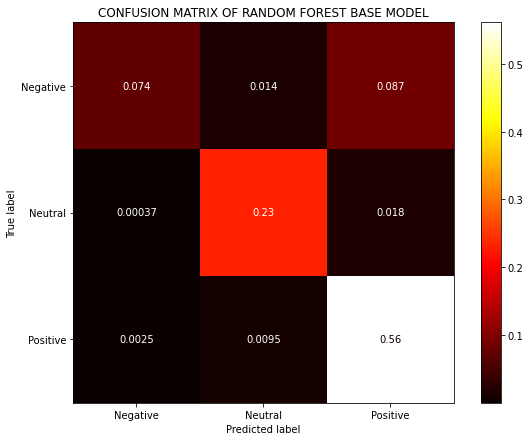

In [56]:
# reference - https://lifewithdata.com/2022/02/06/confusion-matrix-how-to-plot-and-interpret-confusion-matrix/
# create confusion matrix from predictions
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay.from_predictions(
    y_test_rf, rf_predict, display_labels=['Negative','Neutral','Positive'],labels=model_rf.classes_, ax=ax, cmap='hot',normalize='all')
ax.set_title("CONFUSION MATRIX OF RANDOM FOREST BASE MODEL")
plt.show()
# note - the code is been adapted from the reference and it is modified

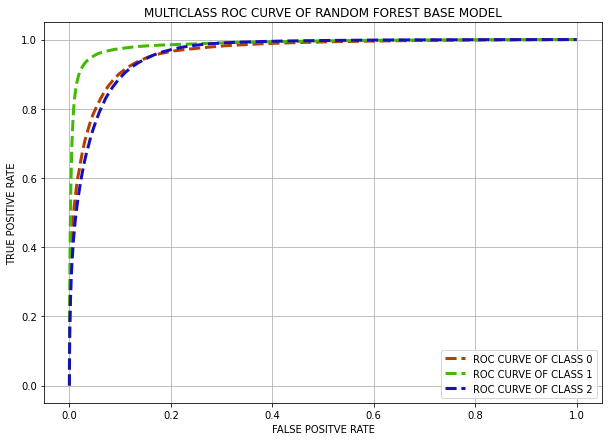

In [37]:
# reference - https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
# roc curves for random forest model
fig, ax = plt.subplots(figsize=(10, 7))
pred_prob_rf = model_rf.predict_proba(X_test_rf_vector)
fpr = {}
tpr = {}
thresh ={}
n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_rf, pred_prob_rf[:,i], pos_label=i)
    
# plot the roc curve   
plt.plot(fpr[0], tpr[0], linestyle='--',color='#B83D00', label='ROC CURVE OF CLASS 0', linewidth=3)
plt.plot(fpr[1], tpr[1], linestyle='--',color='#45B807', label='ROC CURVE OF CLASS 1', linewidth=3)
plt.plot(fpr[2], tpr[2], linestyle='--',color='#1510B8', label='ROC CURVE OF CLASS 2', linewidth=3)
plt.title('MULTICLASS ROC CURVE OF RANDOM FOREST BASE MODEL')
plt.xlabel('FALSE POSITVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.grid()
plt.legend(loc='best')  
plt.show()
# note - the code is been adapted from the reference and it is modified

In [38]:
# reference - https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
# calculate the roc auc score
print(roc_auc_score(y_test_rf,pred_prob_rf, multi_class='ovr'))
# note - the code is been adapted from the reference and it is modified

0.970065022192233


### Random Forest Tuned Model

In [39]:
# reference - https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
# applying the hyperparameter for the grid search
from sklearn.model_selection import GridSearchCV
n_estimators = [10, 20]
max_features = ['sqrt', 'log2']
grid_rf = dict(n_estimators=n_estimators,max_features=max_features)
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=grid_rf, n_jobs=-1, cv=3, scoring='accuracy',error_score=0)
grid_result_rf = grid_search_rf.fit(X_train_rf_vector, y_train_rf)
best_params_rf = grid_result_rf.best_params_
best_params_rf
# note - the code is been adapted from the reference and it is modified

{'max_features': 'sqrt', 'n_estimators': 20}

In [42]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# applying the tuned model
model_rf_tuned = RandomForestClassifier(n_estimators = 20, max_features='sqrt')
start_time_rf_tuned = time.time()
model_rf_tuned.fit(X_train_rf_vector, y_train_rf)
stop_time_rf_tuned = time.time()
rf_predict_tuned = model_rf_tuned.predict(X_test_rf_vector)
# note - the code is been adapted from the reference and it is modified

In [43]:
# calculate the train time of tuned random forest model
training_time_rf_tuned = stop_time_rf_tuned - start_time_rf_tuned
training_time_rf_tuned

8830.47286605835

In [44]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# generating the classification report
print(metrics.classification_report(y_test_rf, rf_predict_tuned))
# note - the code is been adapted from the reference and it is modified

              precision    recall  f1-score   support

           0       0.90      0.45      0.60     28727
           1       0.87      0.91      0.89     41544
           2       0.85      0.95      0.90     94350

    accuracy                           0.86    164621
   macro avg       0.87      0.77      0.80    164621
weighted avg       0.86      0.86      0.84    164621



In [45]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# calculate the accuracy
print(metrics.accuracy_score(y_test_rf, rf_predict_tuned))
# note - the code is been adapted from the reference and it is modified

0.8564763912259068


In [46]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# calculate the precision score
print(precision_score(y_test_rf, rf_predict_tuned,average='macro'))
# note - the code is been adapted from the reference and it is modified

0.8714068759892132


In [47]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# calculate the recall score
print(recall_score(y_test_rf, rf_predict_tuned,average='macro'))
# note - the code is been adapted from the reference and it is modified

0.7731646524286511


In [48]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# calculate the f1 score
print(f1_score(y_test_rf, rf_predict_tuned,average='macro'))
# note - the code is been adapted from the reference and it is modified

0.7959416970291616


In [49]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
# calculate the fbeta score
print(fbeta_score(y_test_rf, rf_predict_tuned,average='macro', beta = 0.7))
# note - the code is been adapted from the reference and it is modified

0.8130149084575883


In [50]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
# calculate the mean absolute error
print(mean_absolute_error(y_test_rf, rf_predict_tuned))
# note - the code is been adapted from the reference and it is modified

0.22968515559983235


In [51]:
# calculate the MSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_rf, rf_predict_tuned,squared=True))
# note - the code is been adapted from the reference and it is modified

0.40200824925131057


In [52]:
# calculate the RMSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_rf, rf_predict_tuned,squared=False))
# note - the code is been adapted from the reference and it is modified

0.6340412046951764


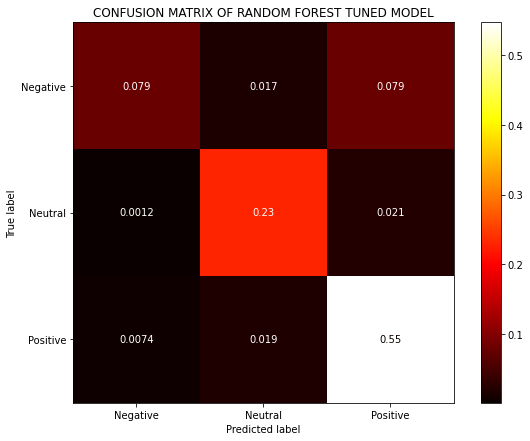

In [53]:
# reference - https://lifewithdata.com/2022/02/06/confusion-matrix-how-to-plot-and-interpret-confusion-matrix/
# create confusion matrix from predictions
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay.from_predictions(
    y_test_rf, rf_predict_tuned, display_labels=['Negative','Neutral','Positive'],labels=model_rf_tuned.classes_, ax=ax, cmap='hot',normalize='all')
ax.set_title("CONFUSION MATRIX OF RANDOM FOREST TUNED MODEL")
plt.show()
# note - the code is been adapted from the reference and it is modified

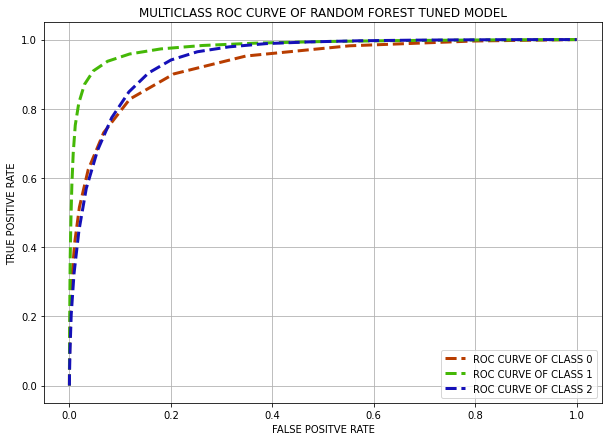

In [54]:
# reference - https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
# roc curves for tuned random forest model
fig, ax = plt.subplots(figsize=(10, 7))
pred_prob_rf_tuned = model_rf_tuned.predict_proba(X_test_rf_vector)
fpr = {}
tpr = {}
thresh ={}
n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_rf, pred_prob_rf_tuned[:,i], pos_label=i)
    
# plot the roc curve   
plt.plot(fpr[0], tpr[0], linestyle='--',color='#B83D00', label='ROC CURVE OF CLASS 0', linewidth=3)
plt.plot(fpr[1], tpr[1], linestyle='--',color='#45B807', label='ROC CURVE OF CLASS 1', linewidth=3)
plt.plot(fpr[2], tpr[2], linestyle='--',color='#1510B8', label='ROC CURVE OF CLASS 2', linewidth=3)
plt.title('MULTICLASS ROC CURVE OF RANDOM FOREST TUNED MODEL')
plt.xlabel('FALSE POSITVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.grid()
plt.legend(loc='best')  
plt.show()
# note - the code is been adapted from the reference and it is modified

In [55]:
# reference - https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
# calculate the roc auc score
print(roc_auc_score(y_test_rf,pred_prob_rf_tuned, multi_class='ovr'))
# note - the code is been adapted from the reference and it is modified

0.9490011451027472
